# Setup

In [ ]:
%pip install torch-geometric

In [1]:
import os
import math
import time
import psutil
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader


In [2]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cpu


In [3]:
def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity

# Graph Classification

In [4]:
# Load the MUTAG dataset
mutag_data = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Split the dataset into train and test sets
mutag_train_dataset = mutag_data[:150]
mutag_test_dataset = mutag_data[150:]

# Create data loaders
mutag_train_loader = DataLoader(mutag_train_dataset, batch_size=32, shuffle=True)
mutag_test_loader = DataLoader(mutag_test_dataset, batch_size=32, shuffle=False)

# Get the number of features and classes from the dataset
num_features = mutag_train_dataset.num_features
num_classes = mutag_test_dataset.num_classes


In [5]:
def compute_path_lengths(loader):
    longest_path = 0
    shortest_path = float('inf')
    average_paths = []

    for data in loader:
        for i in range(data.num_graphs):
            graph = data[i]
            G = to_networkx(graph, to_undirected=True)
            
            # Compute shortest path lengths
            path_lengths = dict(nx.all_pairs_shortest_path_length(G))
            graph_longest_path = 0
            graph_total_path_length = 0
            graph_total_paths = 0
            
            for lengths in path_lengths.values():
                for length in lengths.values():
                    if length > graph_longest_path:
                        graph_longest_path = length
                    if length < shortest_path:
                        shortest_path = length
                    graph_total_path_length += length
                    graph_total_paths += 1

            # Update the overall longest path
            if graph_longest_path > longest_path:
                longest_path = graph_longest_path

            # Calculate the average path length for this graph
            if graph_total_paths > 0:
                graph_average_path = graph_total_path_length / graph_total_paths
                average_paths.append(graph_average_path)
    
    overall_average_path = np.mean(average_paths) if average_paths else 0
    std_average_path = np.std(average_paths) if average_paths else 0
    shortest_path = shortest_path if shortest_path != float('inf') else 0
    
    return int(longest_path), int(shortest_path), overall_average_path, std_average_path

# Compute path lengths for the train loader
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(mutag_train_loader)
print(f'Longest path: {longest_path}')
print(f'Shortest path: {shortest_path}')
print(f'Overall average path: {overall_average_path:.2f}')
print(f'Standard deviation of average paths: {std_average_path:.2f}')

Longest path: 15
Shortest path: 0
Overall average path: 3.42
Standard deviation of average paths: 0.59


## Model Definition

In [6]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.gcn2 = GCN(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [7]:
class GCESN(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
def train(model, loader, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    
    
    # Train and test the models
    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()
        
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)  # Convert edge_index to adjacency matrix

            optimizer.zero_grad() 
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
    
        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')
        

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')

    return 


In [9]:
def test(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return 

## Training

### GCN

#### GCN 1-Layer

GCN1Layer(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 1284

Epoch 1, Loss: 96.71396768093109
Time: 0.09s, CPU: 1.42GB, Memory: 2.88GB
Epoch 2, Loss: 93.50504410266876
Time: 0.01s, CPU: 0.00GB, Memory: 2.88GB
Epoch 3, Loss: 91.8419896364212
Time: 0.01s, CPU: 1.78GB, Memory: 2.88GB
Epoch 4, Loss: 90.46569216251373
Time: 0.01s, CPU: 1.34GB, Memory: 2.88GB
Epoch 5, Loss: 88.50702345371246
Time: 0.01s, CPU: 0.00GB, Memory: 2.88GB
Epoch 6, Loss: 86.38542366027832
Time: 0.01s, CPU: 2.18GB, Memory: 2.88GB
Epoch 7, Loss: 84.17258870601654
Time: 0.01s, CPU: 3.00GB, Memory: 2.88GB
Epoch 8, Loss: 81.81487572193146
Time: 0.01s, CPU: 0.00GB, Memory: 2.88GB
Epoch 9, Loss: 79.72315526008606
Time: 0.01s, CPU: 0.00GB, Memory: 2.88GB
Epoch 10, Loss: 78.13580918312073
Time: 0.01s, CPU: 0.00GB, Memory: 2.88GB
Epoch 11, Loss: 76.90047818422318
Time: 0.01s, CPU: 0.00GB, Memory: 2.88GB
Epoch 12, Loss: 76.11045837402344
Time: 0.01s,

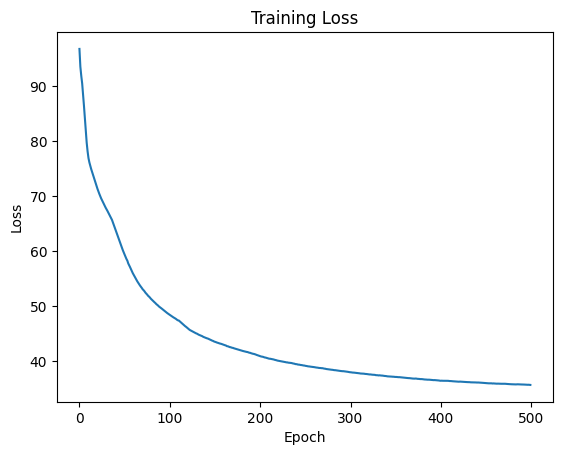

Model saved to models/gcn_1l_graph.pth
Model saved to models/gcn_1l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.12GB
Average Memory Usage: 2.86GB

Total Training Time: 5.22s
Max CPU Usage: 3.43GB
Max Memory Usage: 2.88GB


In [10]:
# Create model instances
model1 = GCN1Layer(num_features, num_classes)
print(model1)
print(f"Total number of trainable parameters: {(model1.count_parameters())*2}\n")
train(model1, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_1l_graph.pth')

#### GCN 2-Layer

GCN2Layer(
  (gcn1): GCN (7 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 9604

Epoch 1, Loss: 97.16585290431976
Time: 0.02s, CPU: 0.93GB, Memory: 2.83GB
Epoch 2, Loss: 91.46142411231995
Time: 0.01s, CPU: 0.80GB, Memory: 2.83GB
Epoch 3, Loss: 88.28254663944244
Time: 0.05s, CPU: 6.36GB, Memory: 2.84GB
Epoch 4, Loss: 84.55763399600983
Time: 0.02s, CPU: 5.86GB, Memory: 2.84GB
Epoch 5, Loss: 80.75717496871948
Time: 0.01s, CPU: 3.08GB, Memory: 2.84GB
Epoch 6, Loss: 76.53260433673859
Time: 0.01s, CPU: 1.60GB, Memory: 2.84GB
Epoch 7, Loss: 73.58288276195526
Time: 0.01s, CPU: 2.18GB, Memory: 2.84GB
Epoch 8, Loss: 72.83806717395782
Time: 0.01s, CPU: 0.80GB, Memory: 2.84GB
Epoch 9, Loss: 71.83973115682602
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 10, Loss: 70.6589081287384
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 11, Loss: 70.30955308675766
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 12, Loss: 69.35

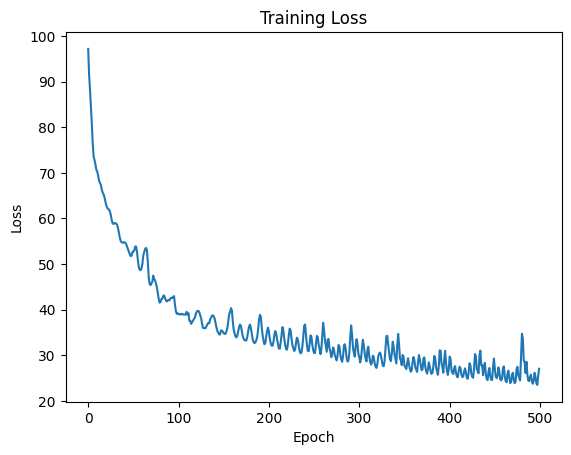

Model saved to models/gcn_2l_graph.pth
Model saved to models/gcn_2l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.26GB
Average Memory Usage: 2.84GB

Total Training Time: 6.04s
Max CPU Usage: 6.36GB
Max Memory Usage: 2.85GB


In [11]:
model2 = GCN2Layer(num_features, num_classes)
print(model2)
print(f"Total number of trainable parameters: {(model2.count_parameters())*2}\n")
train(model2, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_2l_graph.pth')

### GCESN

#### Variant 1

GCESN(
  (fc): Linear(in_features=7, out_features=2, bias=True)
)
Total number of trainable parameters: 16

Epoch 1, Loss: 246.38732266426086
Time: 0.02s, CPU: 1.01GB, Memory: 2.85GB
Epoch 2, Loss: 128.53887033462524
Time: 0.01s, CPU: 3.00GB, Memory: 2.86GB
Epoch 3, Loss: 90.40594816207886
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 4, Loss: 99.91256093978882
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 5, Loss: 79.38778066635132
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 6, Loss: 85.33123099803925
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 7, Loss: 80.51869833469391
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 8, Loss: 78.50536012649536
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 9, Loss: 78.88183903694153
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 10, Loss: 76.82017934322357
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 11, Loss: 77.04421675205231
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 12, Loss: 76.32210850715637
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB

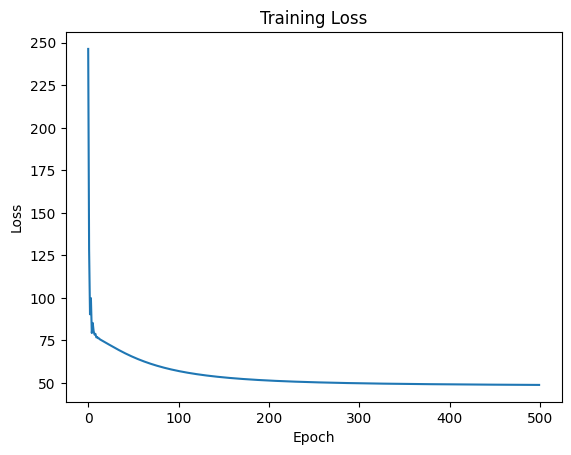

Model saved to models/gcesn_v1_graph.pth
Model saved to models/gcesn_v1_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.11GB
Average Memory Usage: 2.83GB

Total Training Time: 4.90s
Max CPU Usage: 3.34GB
Max Memory Usage: 2.86GB


In [19]:
# Create model instances
gcesn_model = GCESN(num_features, num_features, num_classes, num_iterations=6)
print(gcesn_model)
print(f"Total number of trainable parameters: {gcesn_model.count_parameters()}\n")
train(gcesn_model, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcesn_v1_graph.pth')

#### Variant 2

#### Variant 3

## Evaluation

In [20]:
print('Model 1-Layer GCN')
model1.load_state_dict(torch.load('models/gcn_1l_graph.pth'))
test(model1, mutag_test_loader)

print('\nModel 2-Layer GCN')
model2.load_state_dict(torch.load('models/gcn_2l_graph.pth'))
test(model2, mutag_test_loader)

print('\nModel GCESN Var-1')
gcesn_model.load_state_dict(torch.load('models/gcesn_v1_graph.pth'))
test(gcesn_model, mutag_test_loader)

Model 1-Layer GCN
Accuracy: 0.7895
Sensitivity: 0.8077
Specificity: 0.7500

Model 2-Layer GCN
Accuracy: 0.8421
Sensitivity: 0.8462
Specificity: 0.8333

Model GCESN Var-1
Accuracy: 0.8158
Sensitivity: 0.8077
Specificity: 0.8333


# Node Classification

In [59]:
# Load the Cora dataset
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
# transform=T.NormalizeFeatures()
cora_data = cora_dataset[0]

# Example of data attributes
print(cora_data)
print("Node feature shape:", cora_data.x.shape)
print("Edge index shape:", cora_data.edge_index.shape)
print("Number of classes:", cora_dataset.num_classes)
print("Number of node features:", cora_dataset.num_node_features)

# Splitting the data into train, validation, and test sets
train_mask = cora_data.train_mask
val_mask = cora_data.val_mask
test_mask = cora_data.test_mask


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])
Number of classes: 7
Number of node features: 1433


Processing...
Done!


## GCN

In [65]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        # print(f'x shape: {x.shape}, adj shape: {adj.shape}')
        x = F.relu(self.gcn1(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.gcn2 = GCN(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### Training

In [66]:
def train_gcn(model, data, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    

    adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)  # Convert edge_index to adjacency matrix
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        optimizer.zero_grad()
        output = model(data.x, adj_matrix)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss = loss.item()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')

    return 



GCN1Layer(
  (gcn1): GCN (1433 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Loss: 2.5315744876861572
Time: 0.05s, CPU: 0.95GB, Memory: 2.79GB
Epoch 2, Loss: 2.009591579437256
Time: 0.01s, CPU: 3.00GB, Memory: 2.79GB
Epoch 3, Loss: 1.7564932107925415
Time: 0.01s, CPU: 1.00GB, Memory: 2.79GB
Epoch 4, Loss: 1.6120637655258179
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 5, Loss: 1.497754693031311
Time: 0.01s, CPU: 3.20GB, Memory: 2.79GB
Epoch 6, Loss: 1.3904458284378052
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 7, Loss: 1.2899633646011353
Time: 0.01s, CPU: 3.00GB, Memory: 2.79GB
Epoch 8, Loss: 1.195993423461914
Time: 0.01s, CPU: 1.34GB, Memory: 2.79GB
Epoch 9, Loss: 1.1081916093826294
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 10, Loss: 1.025496482849121
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 11, Loss: 0.9445194602012634
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 12, Loss: 0.8635233640670776

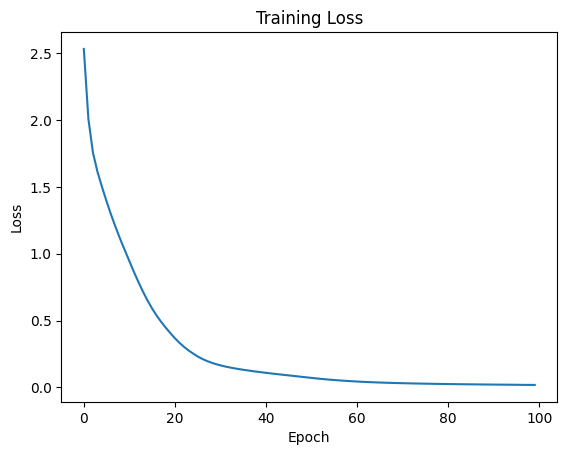

Model saved to models/gcn_1l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.12GB
Average Memory Usage: 2.79GB

Total Training Time: 0.95s
Max CPU Usage: 3.20GB
Max Memory Usage: 2.79GB


In [68]:
# Create model instances
model1 = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(model1)
print(f"Total number of trainable parameters: {model1.count_parameters()}\n")
train_gcn(model1, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_1l_node.pth')


GCN2Layer(
  (gcn1): GCN (1433 -> 16)
  (gcn2): GCN (16 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Loss: 2.840940237045288
Time: 0.02s, CPU: 0.80GB, Memory: 2.80GB
Epoch 2, Loss: 2.2725307941436768
Time: 0.02s, CPU: 2.40GB, Memory: 2.80GB
Epoch 3, Loss: 2.1306426525115967
Time: 0.02s, CPU: 4.40GB, Memory: 2.80GB
Epoch 4, Loss: 1.813894271850586
Time: 0.02s, CPU: 3.08GB, Memory: 2.80GB
Epoch 5, Loss: 1.5857995748519897
Time: 0.01s, CPU: 4.00GB, Memory: 2.80GB
Epoch 6, Loss: 1.5072133541107178
Time: 0.02s, CPU: 2.29GB, Memory: 2.80GB
Epoch 7, Loss: 1.4421696662902832
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 8, Loss: 1.3977277278900146
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 9, Loss: 1.3558145761489868
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 10, Loss: 1.3166905641555786
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 11, Loss: 1.2556278705596924
Time: 0.01s, CPU: 0.00GB, Memory: 2.80GB
Epoch 1

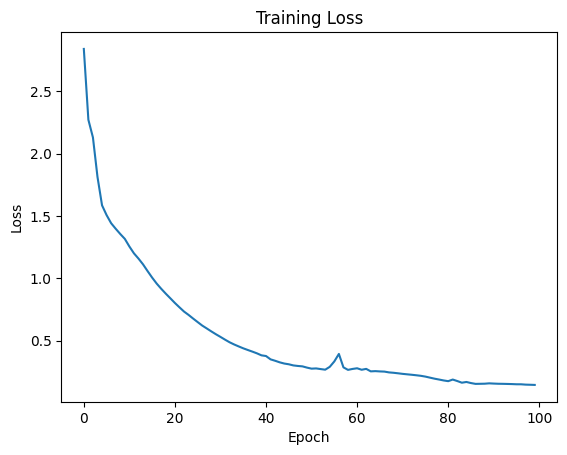

Model saved to models/gcn_2l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.32GB
Average Memory Usage: 2.80GB

Total Training Time: 1.45s
Max CPU Usage: 4.40GB
Max Memory Usage: 2.80GB


In [70]:

model2 = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(model2)
print(f"Total number of trainable parameters: {model2.count_parameters()}\n")
train_gcn(model2, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_2l_node.pth')

#### Testing

In [72]:
def test_gcn(model, data, mask):
    model.eval()
    y_true = data.y[mask].tolist()
    y_pred = []

    with torch.no_grad():
        adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)
        output = model(data.x, adj_matrix)
        pred = output[mask].argmax(dim=1)
        y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return accuracy

In [74]:
print('Model 1-Layer GCN')
model1.load_state_dict(torch.load('models/gcn_1l_node.pth'))
test_gcn(model1, cora_data, cora_data.test_mask)

print('\nModel 2-Layer GCN')
model2.load_state_dict(torch.load('models/gcn_2l_node.pth'))
test_gcn(model2, cora_data, cora_data.test_mask)

Model 1-Layer GCN
Accuracy: 0.8493
Sensitivity: 0.9610
Specificity: 0.7246

Model 2-Layer GCN
Accuracy: 0.9529
Sensitivity: 0.9750
Specificity: 0.9333


0.9529411764705882

## Reservoir-GCN